loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
=== Faster R-CNN ===
Loading and preparing results...
DONE (t=2.17s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.55s).
Accumulating evaluation results...
DONE (t=2.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.211
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.403
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.482
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.307
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.485
 Average Recall     (AR) @[ IoU=0.50:0.95 |

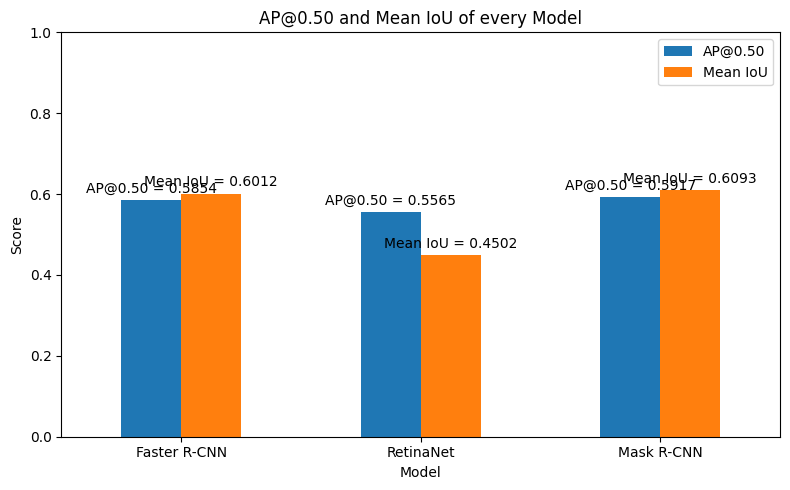

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

#Path to the COCO files and models
ANNOTATIONS = "../coco/annotations/instances_val2017.json"
PREDICTIONS = {
    "Faster R-CNN": "../models/predictions_fasterrcnn.json",
    "RetinaNet":    "../models/predictions_retinanet.json",
    "Mask R-CNN":   "../models/predictions_maskrcnn.json",
}

coco_gt = COCO(ANNOTATIONS)

#IoU function
def compute_mean_iou(coco_gt, coco_dt, iou_thresh=0.5):
    mean_ious = []
    for img_id in coco_gt.getImgIds():
        gt_anns = coco_gt.loadAnns(coco_gt.getAnnIds(imgIds=img_id))
        dt_anns = coco_dt.loadAnns(coco_dt.getAnnIds(imgIds=img_id))

        gt_boxes = []
        for ann in gt_anns:
            x, y, w, h = ann["bbox"]
            gt_boxes.append([x, y, x+w, y+h])

        dt_boxes = []
        for ann in dt_anns:
            if ann["score"] < iou_thresh:
                continue
            x, y, w, h = ann["bbox"]
            dt_boxes.append([x, y, x+w, y+h])

        for gb in gt_boxes:
            if not dt_boxes:
                mean_ious.append(0.0)
                continue
            ious = []
            for db in dt_boxes:
                xA, yA = max(gb[0], db[0]), max(gb[1], db[1])
                xB, yB = min(gb[2], db[2]), min(gb[3], db[3])
                interA = max(0, xB-xA) * max(0, yB-yA)
                areaA = (gb[2]-gb[0])*(gb[3]-gb[1])
                areaB = (db[2]-db[0])*(db[3]-db[1])
                union = areaA + areaB - interA
                ious.append(interA/union if union>0 else 0)
            mean_ious.append(max(ious))

    return np.mean(mean_ious) if mean_ious else 0.0

#Evaluation making
records = []
for name, pfile in PREDICTIONS.items():
    print(f"=== {name} ===")
    coco_dt = coco_gt.loadRes(pfile)

    coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
    coco_eval.params.imgIds = list(set(coco_gt.getImgIds()) & set(coco_dt.getImgIds()))
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    ap50 = coco_eval.stats[1]  

    mean_iou = compute_mean_iou(coco_gt, coco_dt, iou_thresh=0.5)

    print(f"AP@0.50 = {ap50:.4f}, Mean IoU = {mean_iou:.4f}\n")
    records.append({"Model": name, "AP@0.50": ap50, "Mean IoU": mean_iou})

#Plot making
df = pd.DataFrame(records).set_index("Model")
ax = df.plot.bar(figsize=(8,5))
ax.set_ylim(0,1)
ax.set_ylabel("Score")
plt.title("AP@0.50 and Mean IoU of every Model")
plt.xticks(rotation=0)

ap_labels = [f"AP@0.50 = {v:.4f}" for v in df["AP@0.50"]]
iou_labels = [f"Mean IoU = {v:.4f}" for v in df["Mean IoU"]]
ax.bar_label(ax.containers[0], labels=ap_labels, padding=3)
ax.bar_label(ax.containers[1], labels=iou_labels, padding=3)
plt.tight_layout()
plt.show()

I would like to say that Mask R-CNN has the best ratio of speed and accuracy (according to the IoU and mAP50 metrics results). 
Faster R-CNN has a little bit less score on that metrics however it's still has a good speed and accuracy.
And the last one is RetinaNet model. It has extremely low score of IoU metric regarding other models, but this model offers the acceptable speed losing some accuracy.